# Import Libraries
---

We follow the House price prediction EDA Code [LINK](https://www.kaggle.com/code/bilalpython/house-price-prediction-eda). I really appreciated being able to open the EDA codes.<br/>
Now, we are porting that GPU-based code to [RAPIDS](https://rapids.ai/).<br/>
Our system environments include two NVIDIA GTX 2080 Supers, and the OS is Ubuntu 20.04 LTS.<br/>
I hope you feel the speed increase achieved by just using RAPDIS <br/>
If you see more RAPIDS code, See my github.

<a href="https://github.com/Ign0reLee/STUDY_RAPIDS">
<img  src="https://img.shields.io/badge/github-181717?style=flat-square&logo=github&logoColor=FFFFFF" />
</a>

In [1]:
import time
import os

import cupy as cp
import numpy as np
import pandas as pd

# RAPIDS Library
import cudf
import dask
import dask_cudf
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

# Visualization Library
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
cp.cuda.Device(0).use()

<CUDA Device 0>

# Make Timer
---

Check for CPU-based libraries versus GPU-based libraries.

In [3]:
class Timer:
    def __init__(self, name="cpu"):
        self.name = name
        
    def __enter__(self):
        self.start = time.perf_counter()
        
    def __exit__(self, type, value, trackback):
        self.end = time.perf_counter()
        self.execute_time = self.end - self.start
        print(f"{self.name} execute time : {self.execute_time:.4f} seconds")

# Data Load
---

I run this code on my local system. <br/>
If you want to run it, change the path below.

In [4]:
data_path = "/media/HDD2/Data/UKHousing/price_paid_records.csv"

# Load Data
---

Basically we load data with CSV file format. <br/>
However, loading data on the GPU has some advantages with Parquet format. <br/>
Therefore, we convert CSV files to Parquet files and compare their performance.

In [5]:
with Timer("cpu"):
    df = pd.read_csv(data_path)
    
with Timer("gpu"):
    gdf = cudf.read_csv(data_path)
    

cpu execute time : 24.2651 seconds
gpu execute time : 2.7712 seconds


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/cvmi_jeyoung/anaconda3/envs/rapids/include/rmm/mr/device/cuda_memory_resource.hpp

Now I'm using an NVIDIA 2080 Super (VRAM 8GB), but the data is too large for my GPU.<br/> 
So, I changed the data file format from CSV to Parquet. <br/>
Then, what's going to happen?

In [6]:
with Timer("cpu"):
    df.to_parquet("./data/uk_housing.parquet")
    
# with Timer("gpu"):
#     gdf = cudf.read_csv(data_path)
    

cpu execute time : 21.4157 seconds


In [7]:
with Timer("cpu"):
    df = pd.read_parquet("./data/uk_housing.parquet")
    


cpu execute time : 12.8541 seconds


In [8]:
with Timer("gpu"):
    gdf = cudf.read_parquet("./data/uk_housing.parquet")
    

gpu execute time : 1.1160 seconds


In [9]:
!ls -alh "/media/HDD2/Data/UKHousing/"

합계 2.3G
drwxrwxr-x  2 cvmi_jeyoung cvmi_jeyoung 4.0K  5월 13 16:55 .
drwxrwxr-x 27 cvmi_jeyoung cvmi_jeyoung 4.0K  5월 13 16:50 ..
-rw-rw-r--  1 cvmi_jeyoung cvmi_jeyoung 2.3G  5월  8  2020 price_paid_records.csv


In [10]:
!ls -alh "./data/"

합계 835M
drwxrwxr-x 2 cvmi_jeyoung cvmi_jeyoung 4.0K  5월 13 19:01 .
drwxrwxr-x 4 cvmi_jeyoung cvmi_jeyoung 4.0K  5월 14 16:39 ..
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 835M  5월 14 16:39 uk_housing.parquet


In [11]:
df.head()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18 00:00,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09 00:00,S,N,F,GRAYS,THURROCK,THURROCK,A,A
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30 00:00,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,A
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24 00:00,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,A
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23 00:00,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,A


In [12]:
gdf.head()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18 00:00,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09 00:00,S,N,F,GRAYS,THURROCK,THURROCK,A,A
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30 00:00,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,A
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24 00:00,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,A
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23 00:00,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,A


# Different method
---

So fast! and readable! <br/>
Interestingly the file size was also extremely compressed! (2.3GB -> 835MB) <br/>
Are other tasks also fast?

In [13]:
with Timer("cpu"):
    df.info()

with Timer("gpu"):
    gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22489348 entries, 0 to 22489347
Data columns (total 11 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   Transaction unique identifier      object
 1   Price                              int64 
 2   Date of Transfer                   object
 3   Property Type                      object
 4   Old/New                            object
 5   Duration                           object
 6   Town/City                          object
 7   District                           object
 8   County                             object
 9   PPDCategory Type                   object
 10  Record Status - monthly file only  object
dtypes: int64(1), object(10)
memory usage: 1.8+ GB
cpu execute time : 0.0030 seconds
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 22489348 entries, 0 to 22489347
Data columns (total 11 columns):
 #   Column                             Dtype
---  ------               

In [14]:
with Timer("cpu"):
    print(df.shape)
    
with Timer("gpu"):
    print(gdf.shape)

(22489348, 11)
cpu execute time : 0.0000 seconds
(22489348, 11)
gpu execute time : 0.0000 seconds


In [15]:
with Timer("cpu"):
    new_df = df.sample(n = 100000, random_state=42)
    
with Timer("gpu"):
    new_gdf = gdf.sample(n = 100000, random_state=42)

cpu execute time : 1.2021 seconds
gpu execute time : 0.1177 seconds


In [16]:
with Timer("cpu"):
    print(df.describe())
    
with Timer("gpu"):
    print(gdf.describe())

              Price
count  2.248935e+07
mean   1.782442e+05
std    3.903677e+05
min    1.000000e+00
25%    7.500000e+04
50%    1.300000e+05
75%    2.100000e+05
max    9.890000e+07
cpu execute time : 0.5154 seconds
              Price
count  2.248935e+07
mean   1.782442e+05
std    3.903677e+05
min    1.000000e+00
25%    7.500000e+04
50%    1.300000e+05
75%    2.100000e+05
max    9.890000e+07
gpu execute time : 0.0412 seconds


/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/cudf/core/dataframe.py:5059: FutureWarning: `datetime_is_numeric` is deprecated. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(
/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/cudf/core/series.py:3334: FutureWarning: `datetime_is_numeric` is deprecated and will be removed in a future release. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(


In [17]:
with Timer("cpu"):
    df = df.dropna()
    
with Timer("gpu"):
    gdf = gdf.dropna(0)

cpu execute time : 19.1757 seconds
gpu execute time : 0.0346 seconds


Almost task using GPU faster than CPU. <br/>
And calculation (like aggrgation etc..) more fast

# Value Count
---

Value counting is one of the most important processes in data analysis. 

However, the UK Housing Data contains many instances for each column. 

How many times can the CPU versus the GPU visualize value counts with Seaborn?

/tmp/ipykernel_1885837/2692812696.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
/tmp/ipykernel_1885837/2692812696.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
/tmp/ipykernel_1885837/2692812696.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)


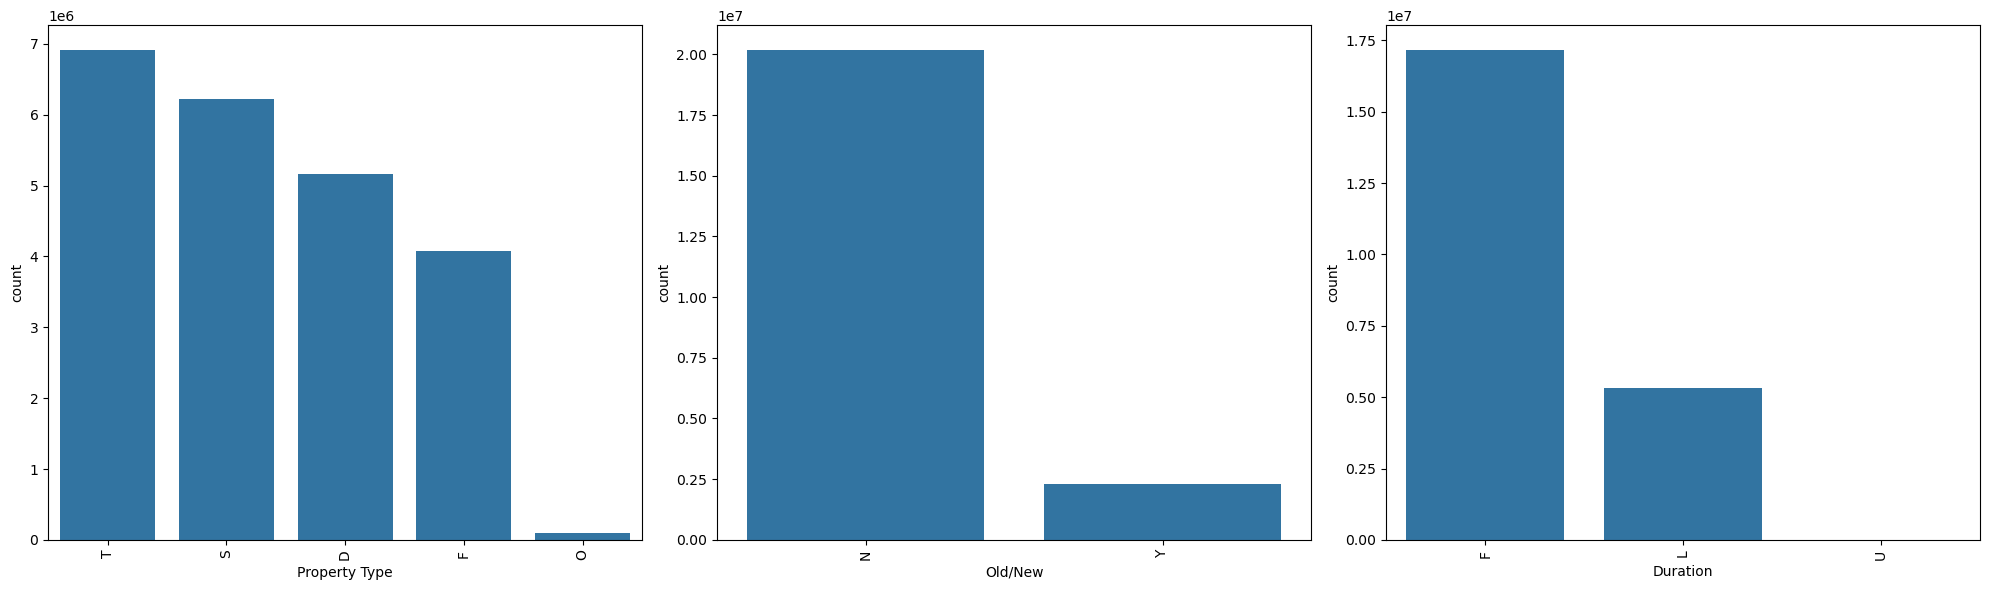

cpu execute time : 67.5644 seconds


In [18]:
cat_cols = ['Property Type','Old/New','Duration']

with Timer("cpu"):
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
    axs = axs.flatten()
    
    for i, var in enumerate(cat_cols):
        
        sns.countplot(x=var,data=df,ax=axs[i])
        
        axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

/tmp/ipykernel_1885837/2498458334.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(count_gdf.index, rotation=90)
/tmp/ipykernel_1885837/2498458334.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(count_gdf.index, rotation=90)
/tmp/ipykernel_1885837/2498458334.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(count_gdf.index, rotation=90)


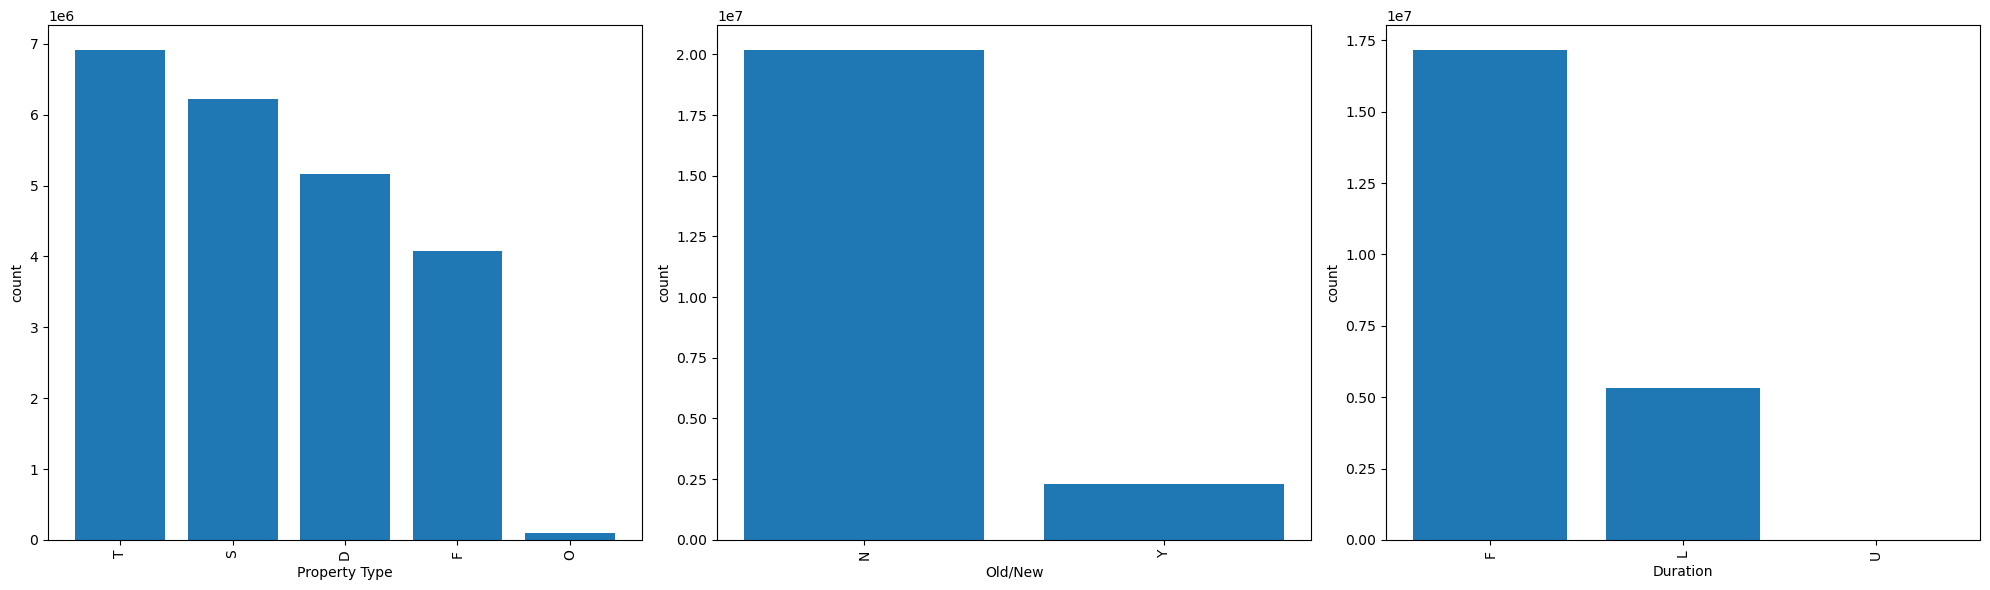

gpu execute time : 0.4322 seconds


In [19]:
with Timer("gpu"):
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
    axs = axs.flatten()
    
    for i, var in enumerate(cat_cols):

        count_gdf = gdf[var].value_counts().to_pandas()
        axs[i].bar(count_gdf.index, count_gdf)
        axs[i].set_ylabel("count")
        axs[i].set_xlabel(var)
        
        axs[i].set_xticklabels(count_gdf.index, rotation=90)
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

# Column by Price
---

/tmp/ipykernel_1885837/1655146428.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
/tmp/ipykernel_1885837/1655146428.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
/tmp/ipykernel_1885837/1655146428.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)


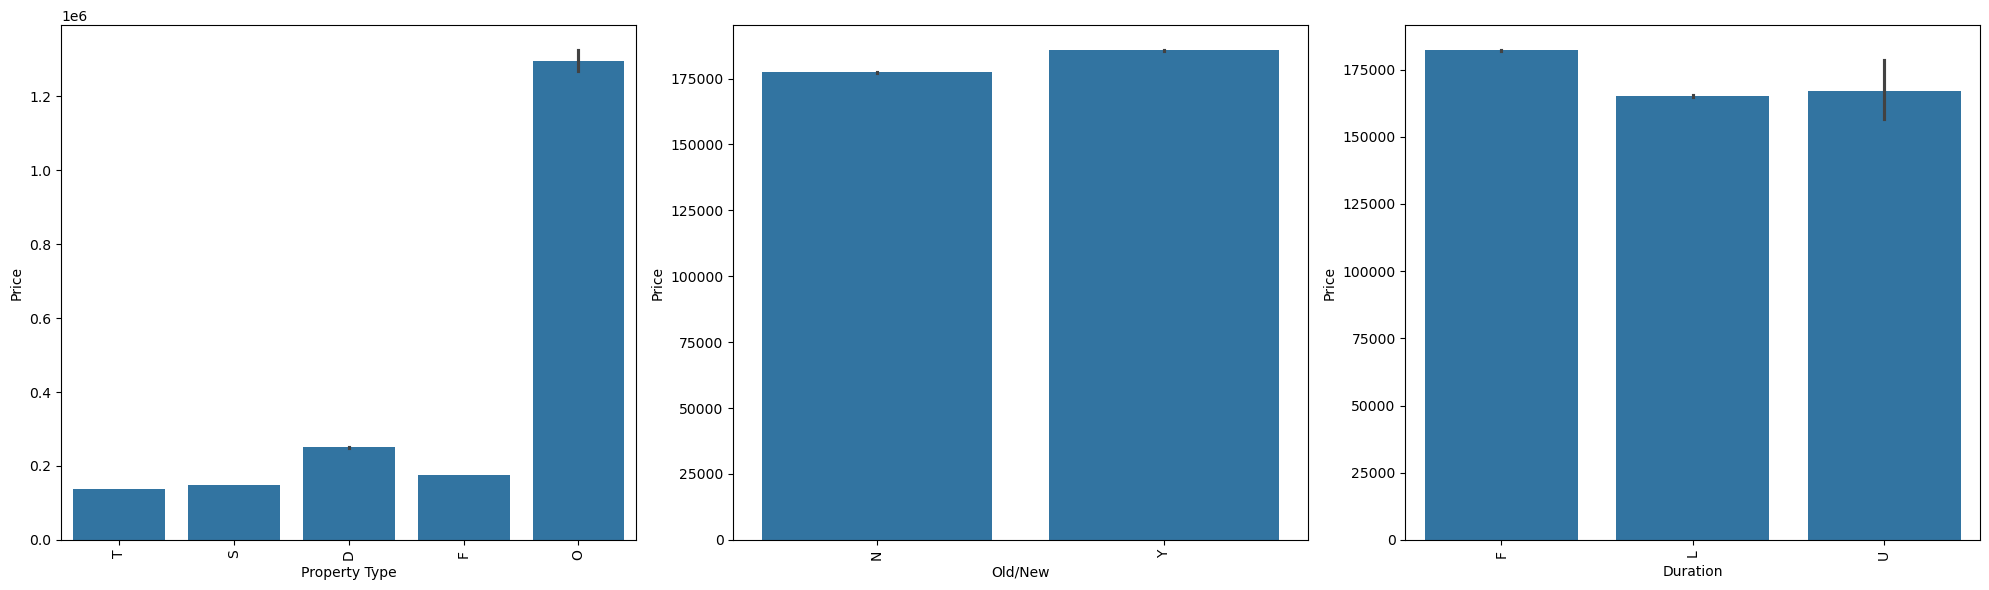

cpu execute time : 1007.2552 seconds


In [20]:
cat_cols = ['Property Type','Old/New','Duration']

with Timer("cpu"):
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
    axs = axs.flatten()
    
    for i, var in enumerate(cat_cols):
        
        sns.barplot(x=var,y='Price',data=df,ax=axs[i])
        
        axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

/tmp/ipykernel_1885837/3278754401.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(prices.index, rotation=90)
/tmp/ipykernel_1885837/3278754401.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(prices.index, rotation=90)
/tmp/ipykernel_1885837/3278754401.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(prices.index, rotation=90)


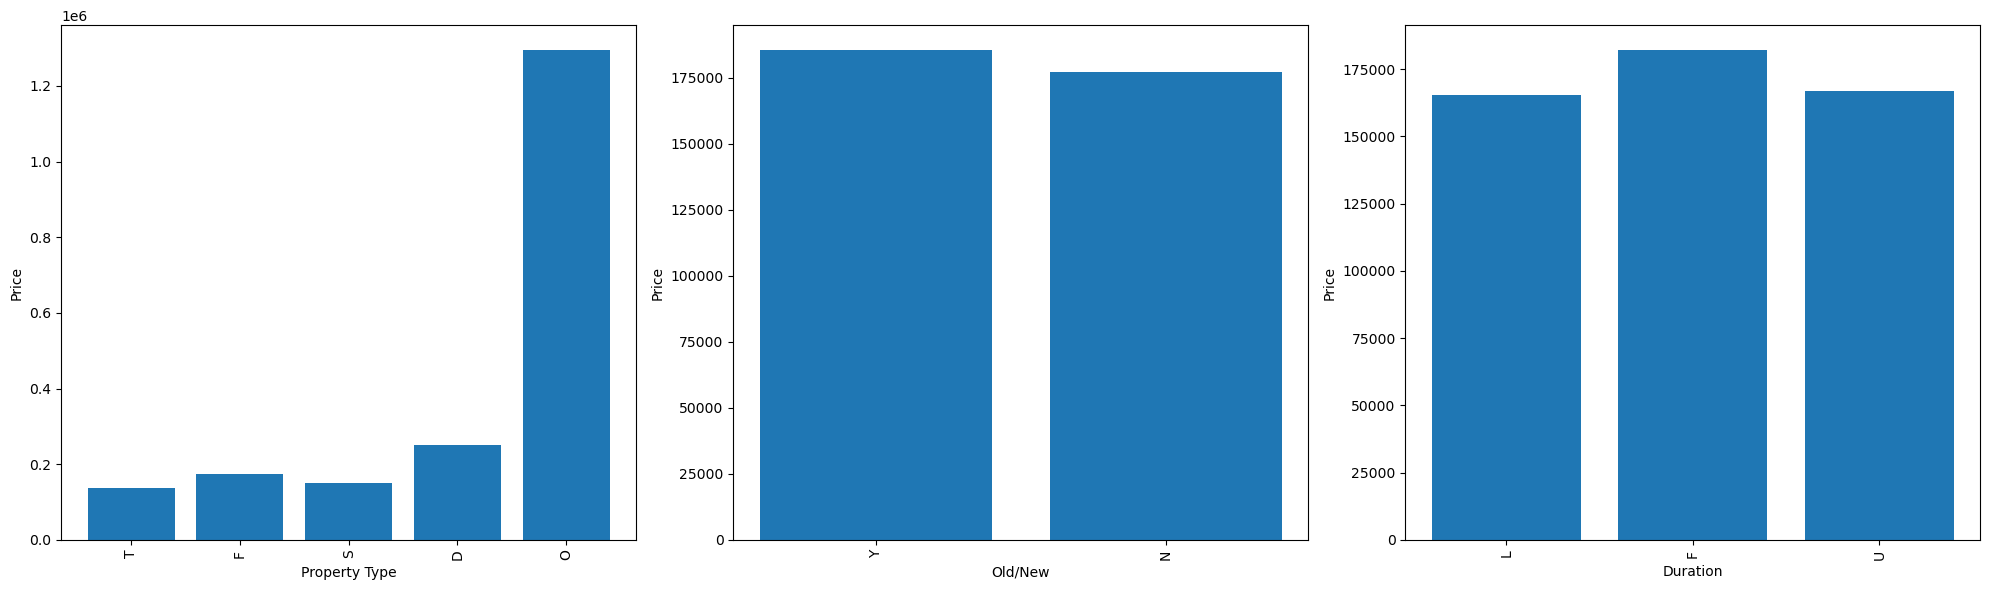

gpu execute time : 0.2964 seconds


In [21]:
with Timer("gpu"):
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
    axs = axs.flatten()
    
    for i, var in enumerate(cat_cols):
        prices = gdf.groupby(var).mean()["Price"].to_pandas()
        axs[i].bar(prices.index, prices)
        axs[i].set_ylabel("Price")
        axs[i].set_xlabel(var)
        
        axs[i].set_xticklabels(prices.index, rotation=90)
        
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

## Conclusion
---

- CPU-based visualization takes too long! 
- However, using GPU-based calculations and visualizations is so fast!

## Using Date Time Index
---

Use a DateTimeIndex to visualize house prices by date.

In [22]:
with Timer("cpu"):
    date_cpu = pd.DatetimeIndex(df['Date of Transfer'])
    df['year']  = date_cpu.year
    df['month'] = date_cpu.month
    df['date']  = date_cpu.day
    
with Timer("gpu"):
    date_gpu = cudf.DatetimeIndex(gdf['Date of Transfer'])
    gdf['year']  = date_gpu.year
    gdf['month'] = date_gpu.month
    gdf['date']  = date_gpu.day

cpu execute time : 5.0439 seconds
gpu execute time : 0.0457 seconds


In [23]:
with Timer("cpu"):
    df.drop(columns=['Transaction unique identifier','Date of Transfer','Record Status - monthly file only'],axis=1,inplace=True)

with Timer("gpu"):
    gdf.drop(columns=['Transaction unique identifier','Date of Transfer','Record Status - monthly file only'],axis=1,inplace=True)


cpu execute time : 1.7096 seconds
gpu execute time : 0.0073 seconds


In [24]:
df

,Price,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,year,month,date
0,25000,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,1995,8,18
1,42500,S,N,F,GRAYS,THURROCK,THURROCK,A,1995,8,9
2,45000,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,1995,6,30
3,43150,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,1995,11,24
4,18899,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,1995,6,23
...,...,...,...,...,...,...,...,...,...,...,...
22489343,175000,S,N,F,LEEDS,LEEDS,WEST YORKSHIRE,A,2017,2,20
22489344,586945,D,N,F,WETHERBY,LEEDS,WEST YORKSHIRE,A,2017,2,15
22489345,274000,D,N,L,HUDDERSFIELD,KIRKLEES,WEST YORKSHIRE,A,2017,2,24
22489346,36000,T,N,F,HALIFAX,CALDERDALE,WEST YORKSHIRE,A,2017,2,22


In [25]:
gdf

,Price,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,year,month,date
0,25000,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,1995,8,18
1,42500,S,N,F,GRAYS,THURROCK,THURROCK,A,1995,8,9
2,45000,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,1995,6,30
3,43150,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,1995,11,24
4,18899,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,1995,6,23
...,...,...,...,...,...,...,...,...,...,...,...
22489343,175000,S,N,F,LEEDS,LEEDS,WEST YORKSHIRE,A,2017,2,20
22489344,586945,D,N,F,WETHERBY,LEEDS,WEST YORKSHIRE,A,2017,2,15
22489345,274000,D,N,L,HUDDERSFIELD,KIRKLEES,WEST YORKSHIRE,A,2017,2,24
22489346,36000,T,N,F,HALIFAX,CALDERDALE,WEST YORKSHIRE,A,2017,2,22


# Visualize price of UK house by date
---

/tmp/ipykernel_1885837/2342349481.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
/tmp/ipykernel_1885837/2342349481.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)


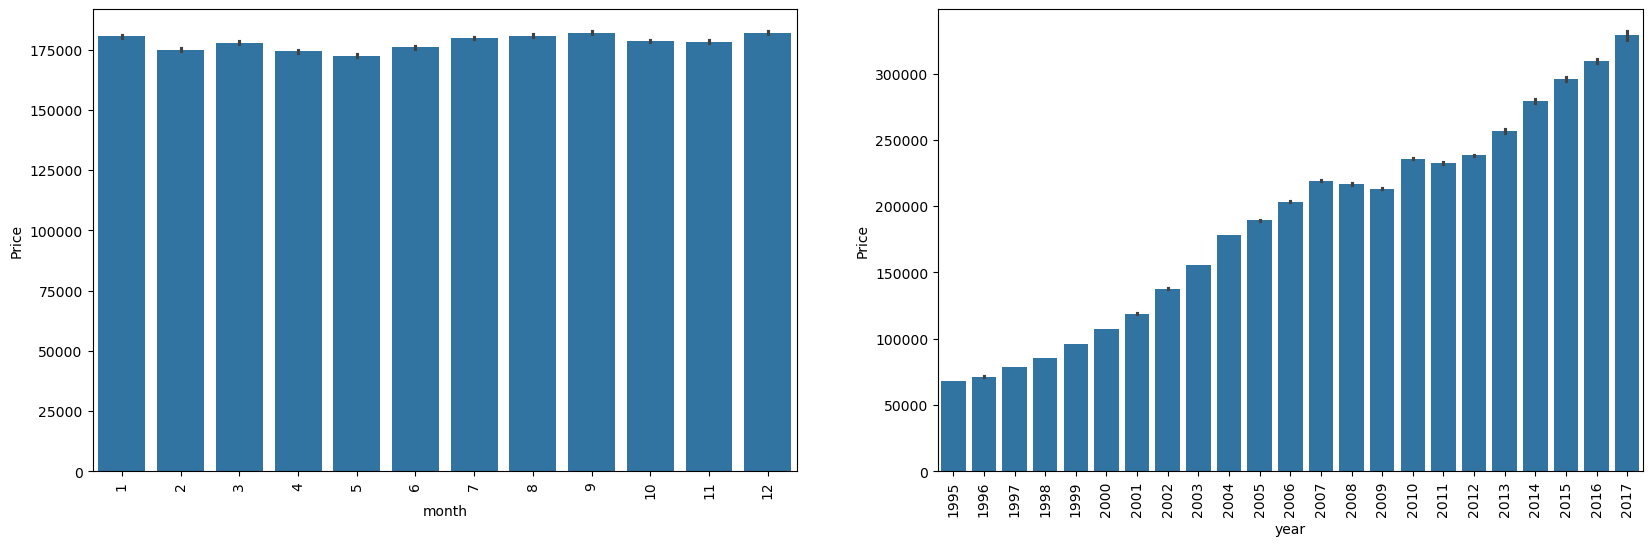

cpu execute time : 454.0829 seconds


In [26]:
date_cols = ['month','year']

with Timer("cpu"):    
    fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(20,6))
    axs = axs.flatten()
    
    for i , var in enumerate(date_cols):
        
        sns.barplot(data=df,x=var,y='Price',ax=axs[i])
        
        axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
        
    fig.get_tight_layout()
    
    plt.show()
    plt.close()

/tmp/ipykernel_1885837/97932624.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(prices.index, rotation=90)
/tmp/ipykernel_1885837/97932624.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(prices.index, rotation=90)


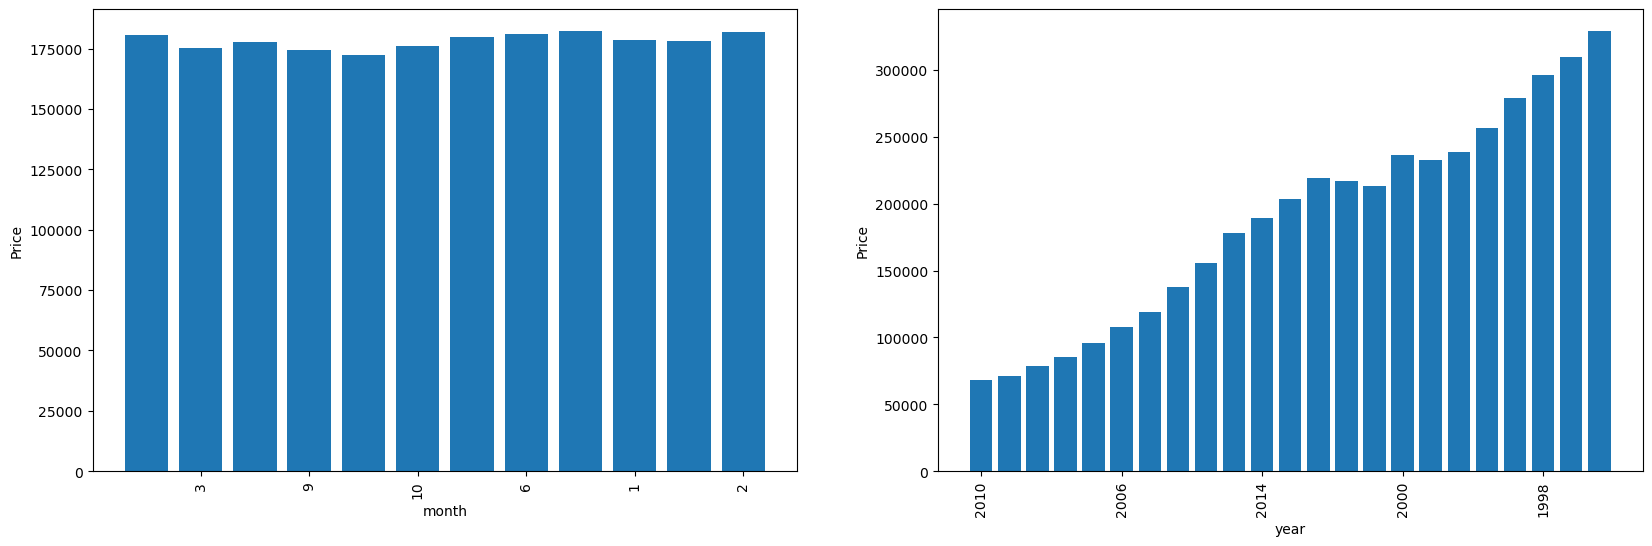

gpu execute time : 0.2541 seconds


In [27]:
with Timer("gpu"):
    fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(20,6))
    axs = axs.flatten()
    
    for i , var in enumerate(date_cols):
        prices = gdf.groupby(var).mean()["Price"].to_pandas()
        axs[i].bar(prices.index, prices)
        axs[i].set_ylabel("Price")
        axs[i].set_xlabel(var)
        
        axs[i].set_xticklabels(prices.index, rotation=90)
        
    fig.get_tight_layout()
    
    plt.show()
    plt.close()

# Count Plot Property Type and Old/New

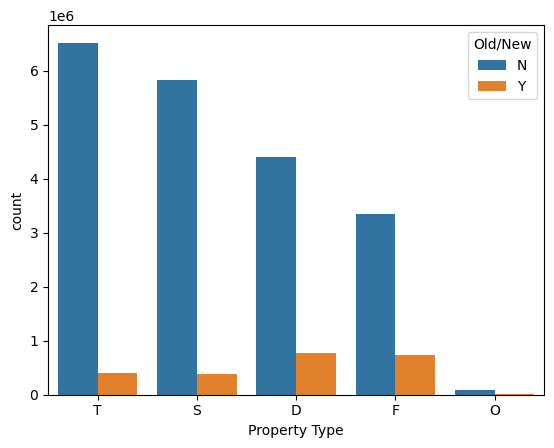

cpu execute time : 38.5009 seconds


In [28]:
with Timer("cpu"):
    sns.countplot(data=df,x='Property Type',hue='Old/New')
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

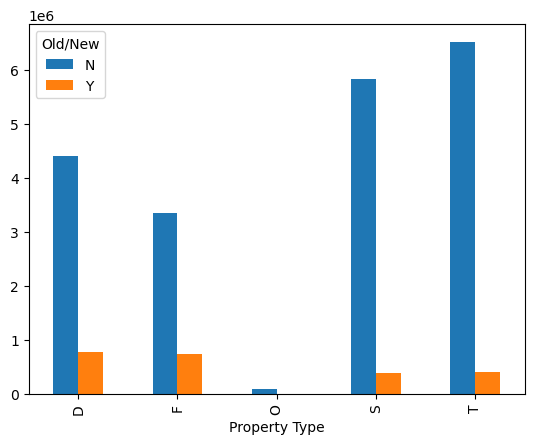

gpu execute time : 0.9089 seconds


In [29]:
with Timer("gpu"):
    fig = plt.figure()
    
    values = gdf[["Property Type","Old/New"]].groupby("Property Type").value_counts().to_pandas()
    values.unstack().plot(kind="bar")
    fig.tight_layout()
    
    plt.show()
    plt.close()

# EDA Town/City
---

cpu execute time : 0.5622 seconds


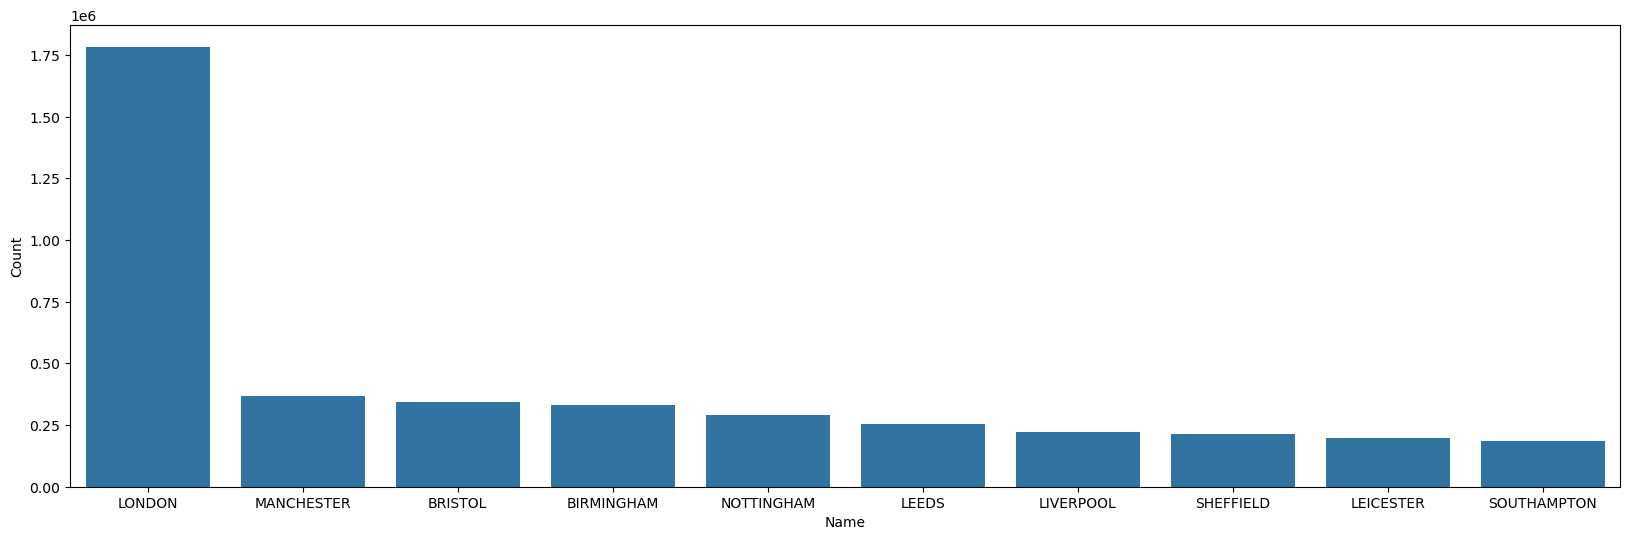

In [30]:
with Timer("cpu"):
    count_cities =  df['Town/City'].value_counts()
    top_cities = count_cities.head(10)
    df_city = pd.DataFrame(top_cities).reset_index()
    df_city.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=df_city,x='Name',y='Count')

gpu execute time : 0.0517 seconds


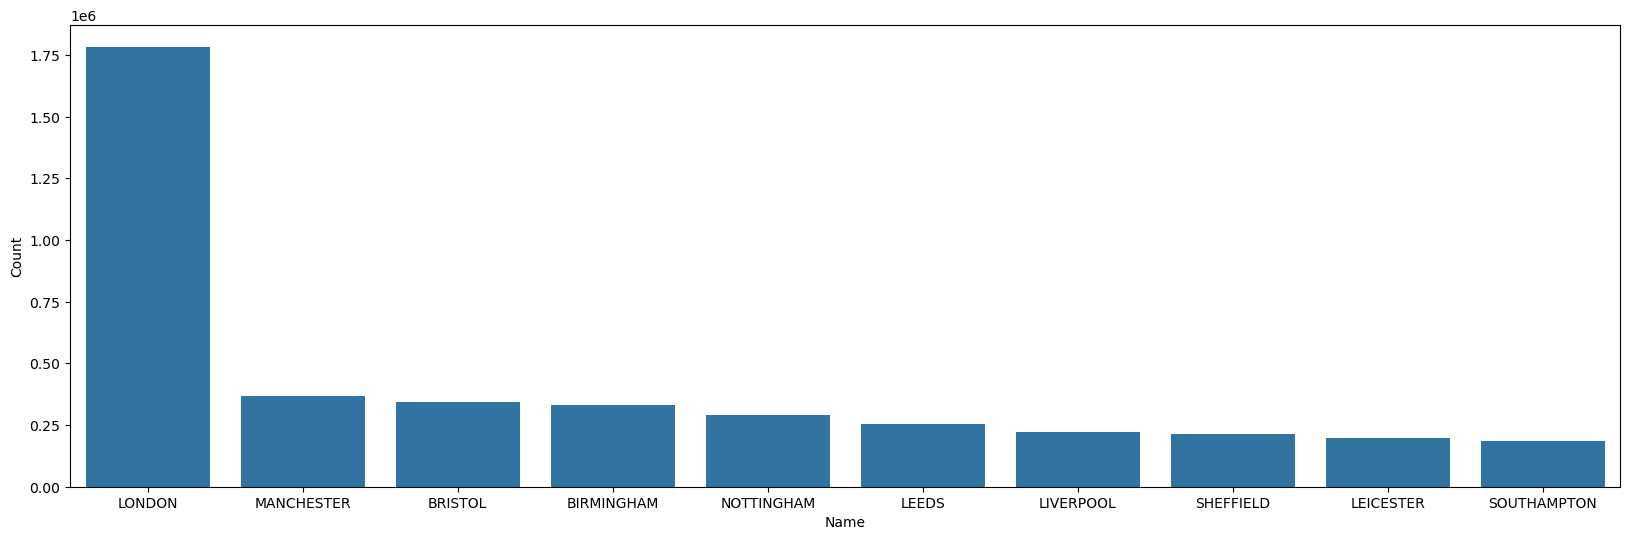

In [31]:
with Timer("gpu"):
    gcount_cities = gdf['Town/City'].value_counts()
    gtop_cities = gcount_cities.head(10)
    gdf_city = cudf.DataFrame(gtop_cities).reset_index()
    gdf_city.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=gdf_city.to_pandas(),x='Name',y='Count')

# EDA District

cpu execute time : 0.5544 seconds


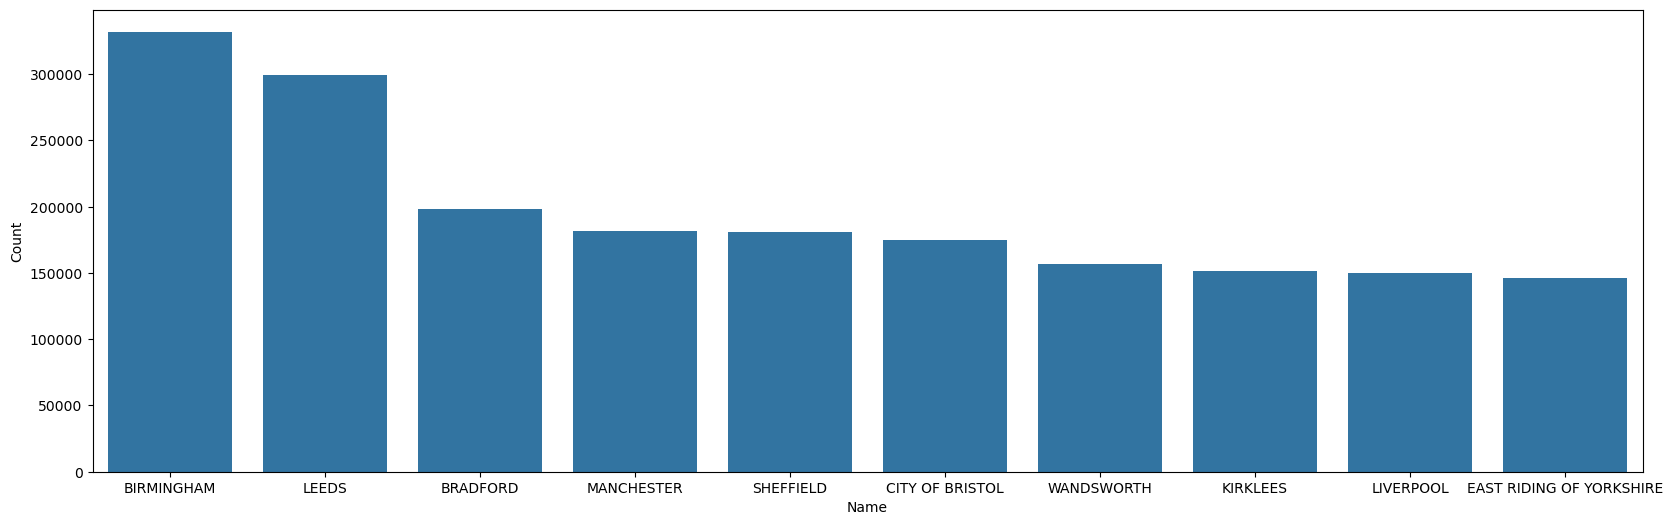

In [32]:
with Timer("cpu"):
    count_district =  df['District'].value_counts()
    top_district = count_district.head(10)
    df_district = pd.DataFrame(top_district).reset_index()
    df_district.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=df_district,x='Name',y='Count')

gpu execute time : 0.0641 seconds


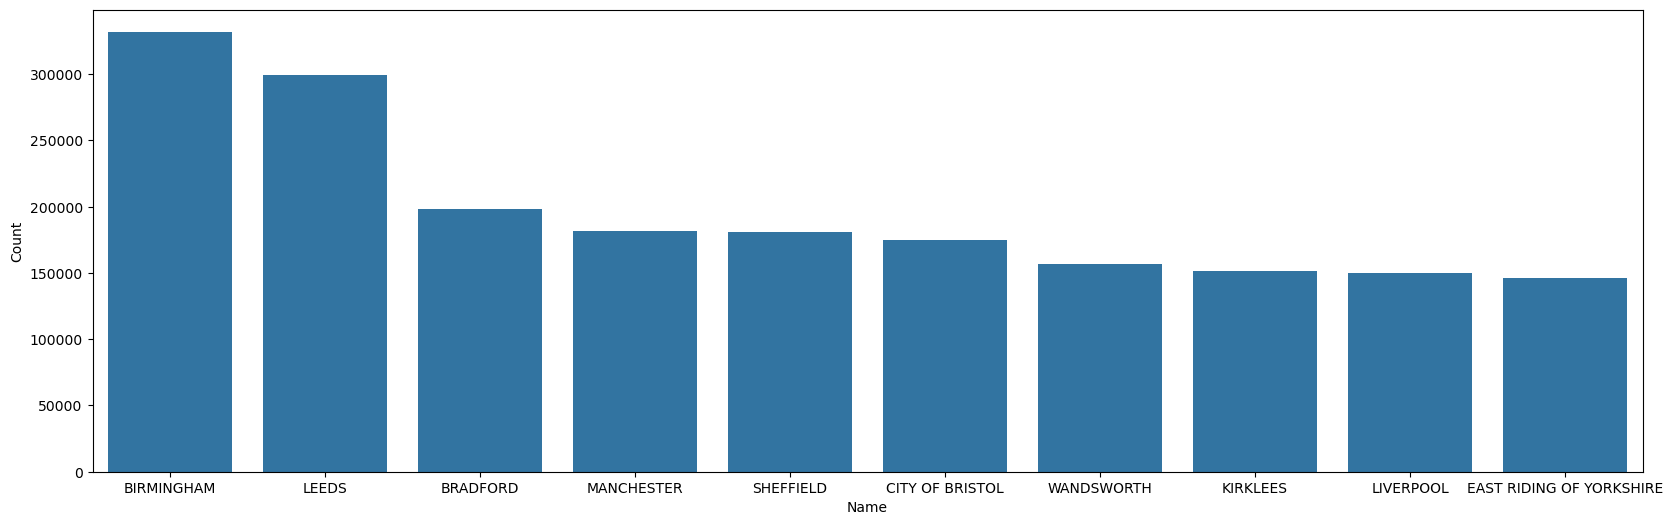

In [33]:
with Timer("gpu"):
    gcount_district =  gdf['District'].value_counts()
    gtop_district = gcount_district.head(10)
    gdf_district = cudf.DataFrame(gtop_district).reset_index()
    gdf_district.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=gdf_district.to_pandas(),x='Name',y='Count')

cpu execute time : 0.5471 seconds


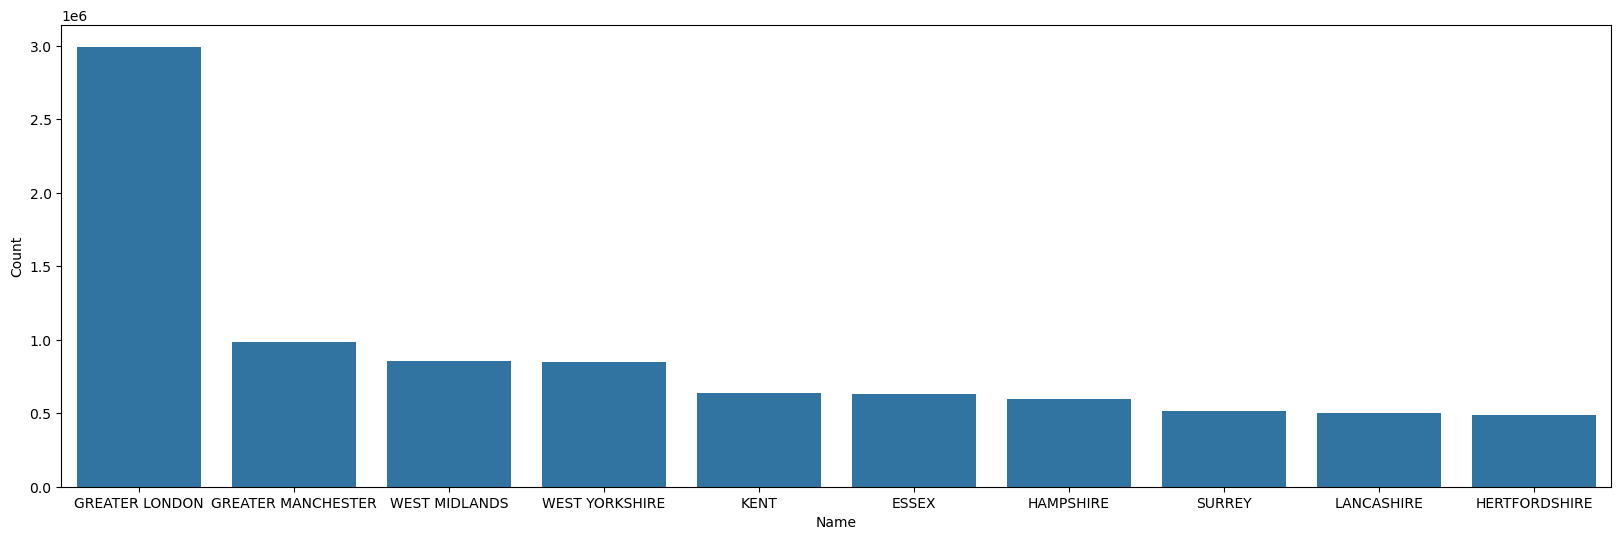

In [34]:
with Timer("cpu"):
    count_county =  df['County'].value_counts()
    top_county = count_county.head(10)
    df_county = pd.DataFrame(top_county).reset_index()
    df_county.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=df_county,x='Name',y='Count')

gpu execute time : 0.0512 seconds


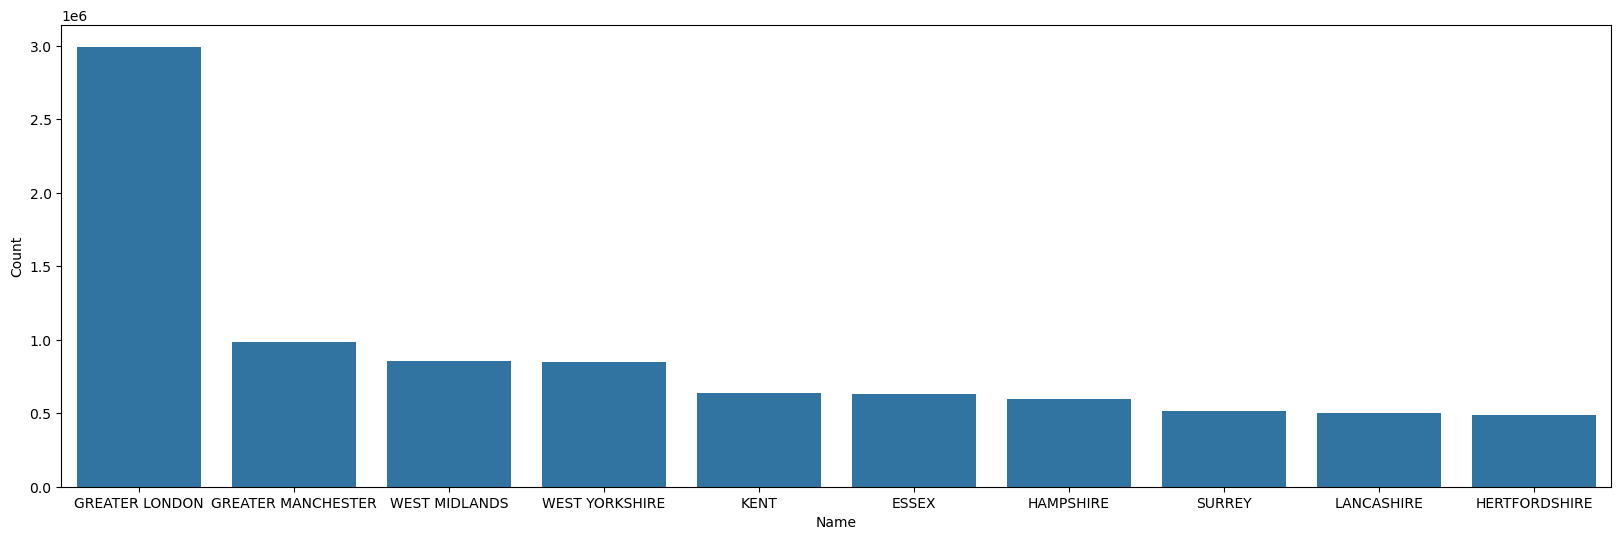

In [35]:
with Timer("gpu"):
    gcount_county =  gdf['County'].value_counts()
    gtop_county = gcount_county.head(10)
    gdf_county = cudf.DataFrame(gtop_county).reset_index()
    gdf_county.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=gdf_county.to_pandas(),x='Name',y='Count')

# EDA Price by Town/City

cpu execute time : 0.0415 seconds


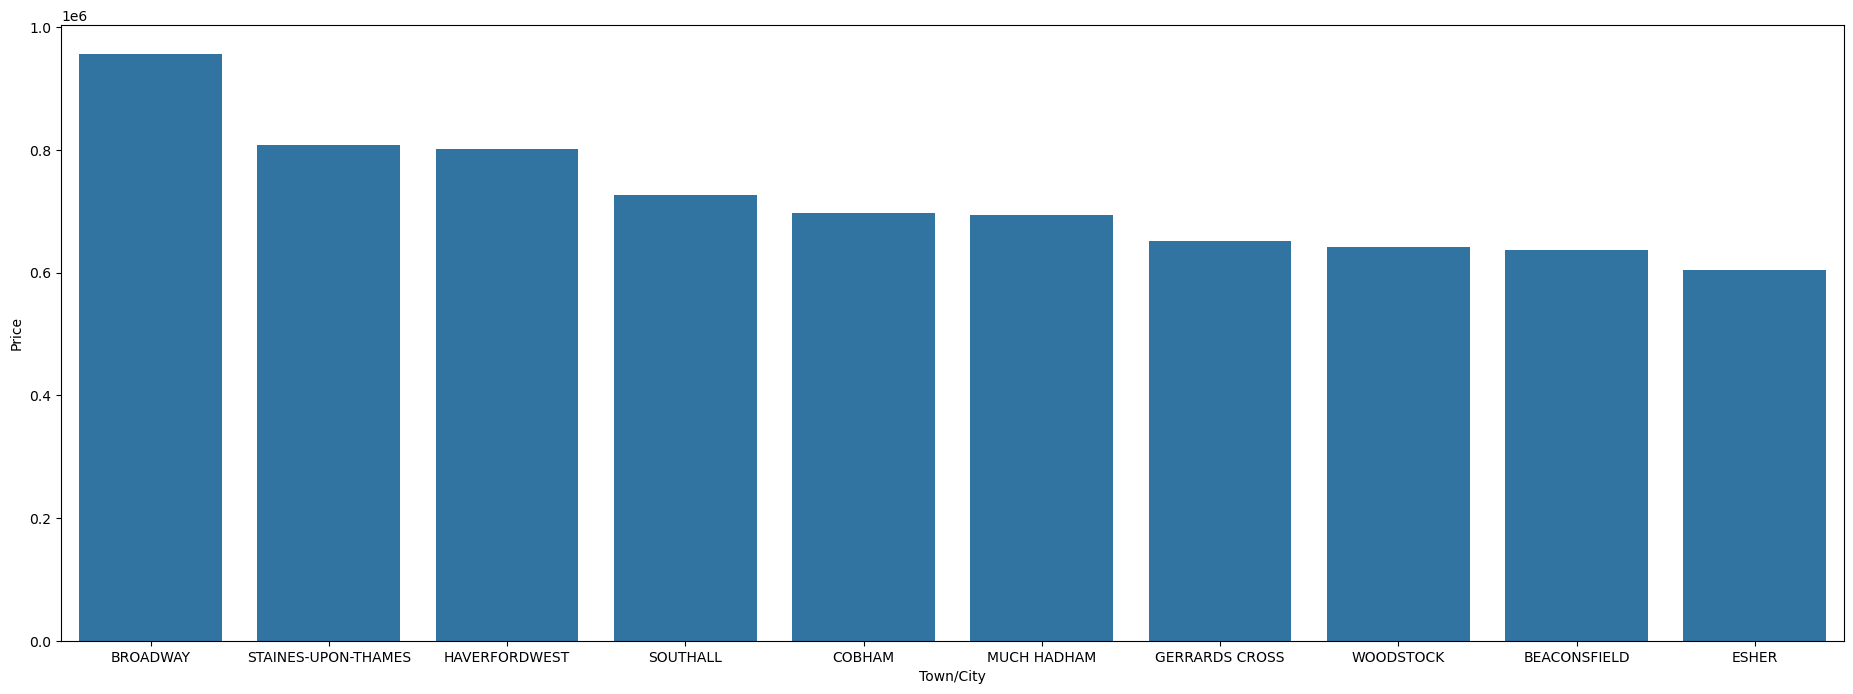

In [36]:
with Timer("cpu"):
    city_df = new_df.groupby('Town/City')['Price'].mean().reset_index()
    city_df = city_df.sort_values(by=['Price'],ascending=False).head(10)
    plt.figure(figsize=(23,8))
    ax = sns.barplot(data = city_df, x = "Town/City", y = "Price")

gpu execute time : 0.0503 seconds


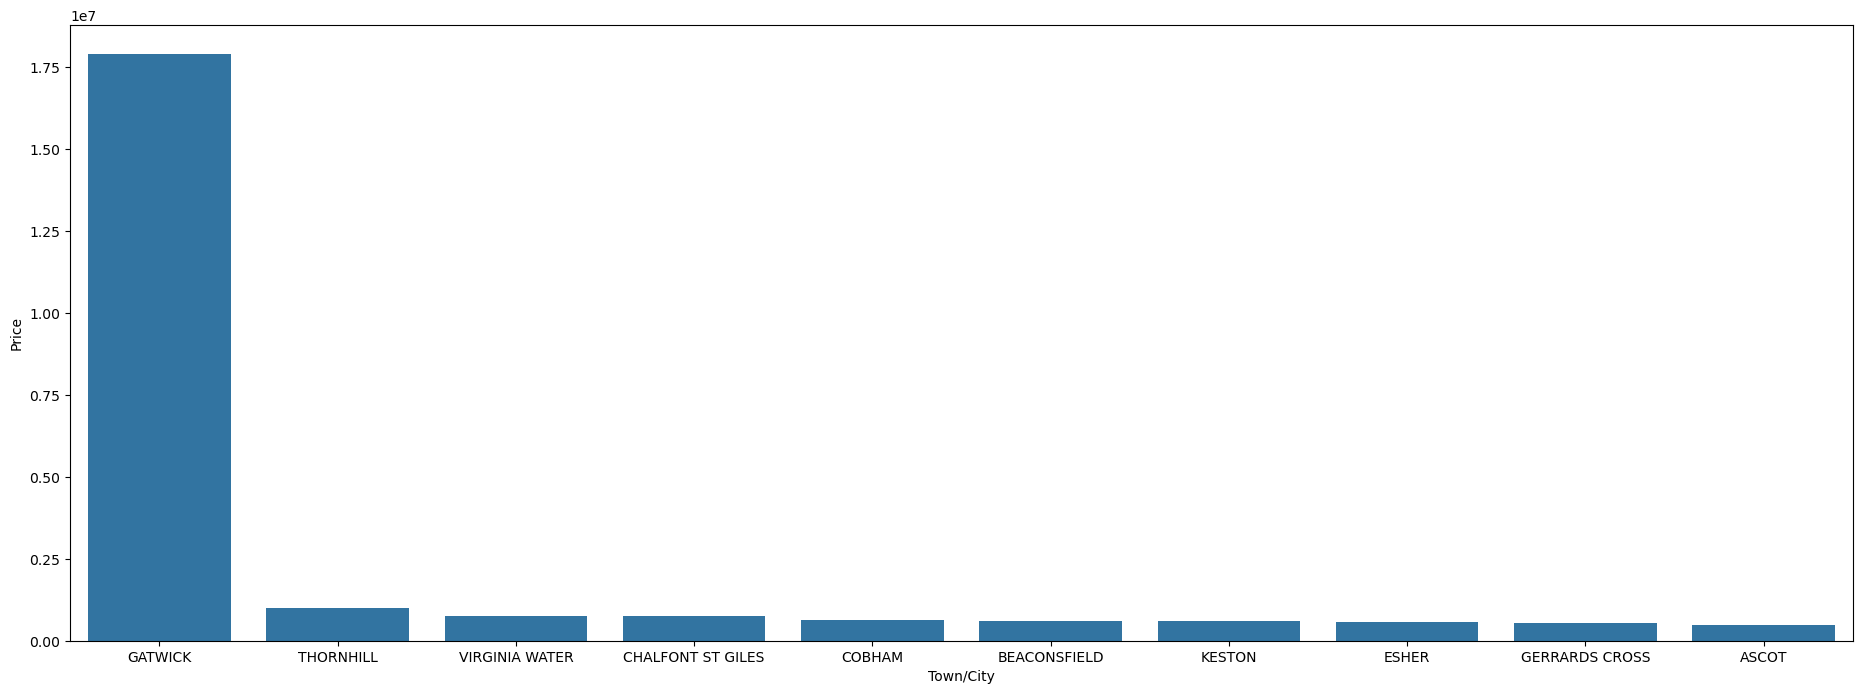

In [37]:
with Timer("gpu"):
    gprice = gdf.groupby("Town/City")['Price'].mean()
    gprice = gprice.sort_values(ascending=False).head(10).reset_index()
    plt.figure(figsize=(23,8))
    ax = sns.barplot(data = gprice.to_pandas(), x = "Town/City", y = "Price")


# EDA Price by District

cpu execute time : 1.1111 seconds


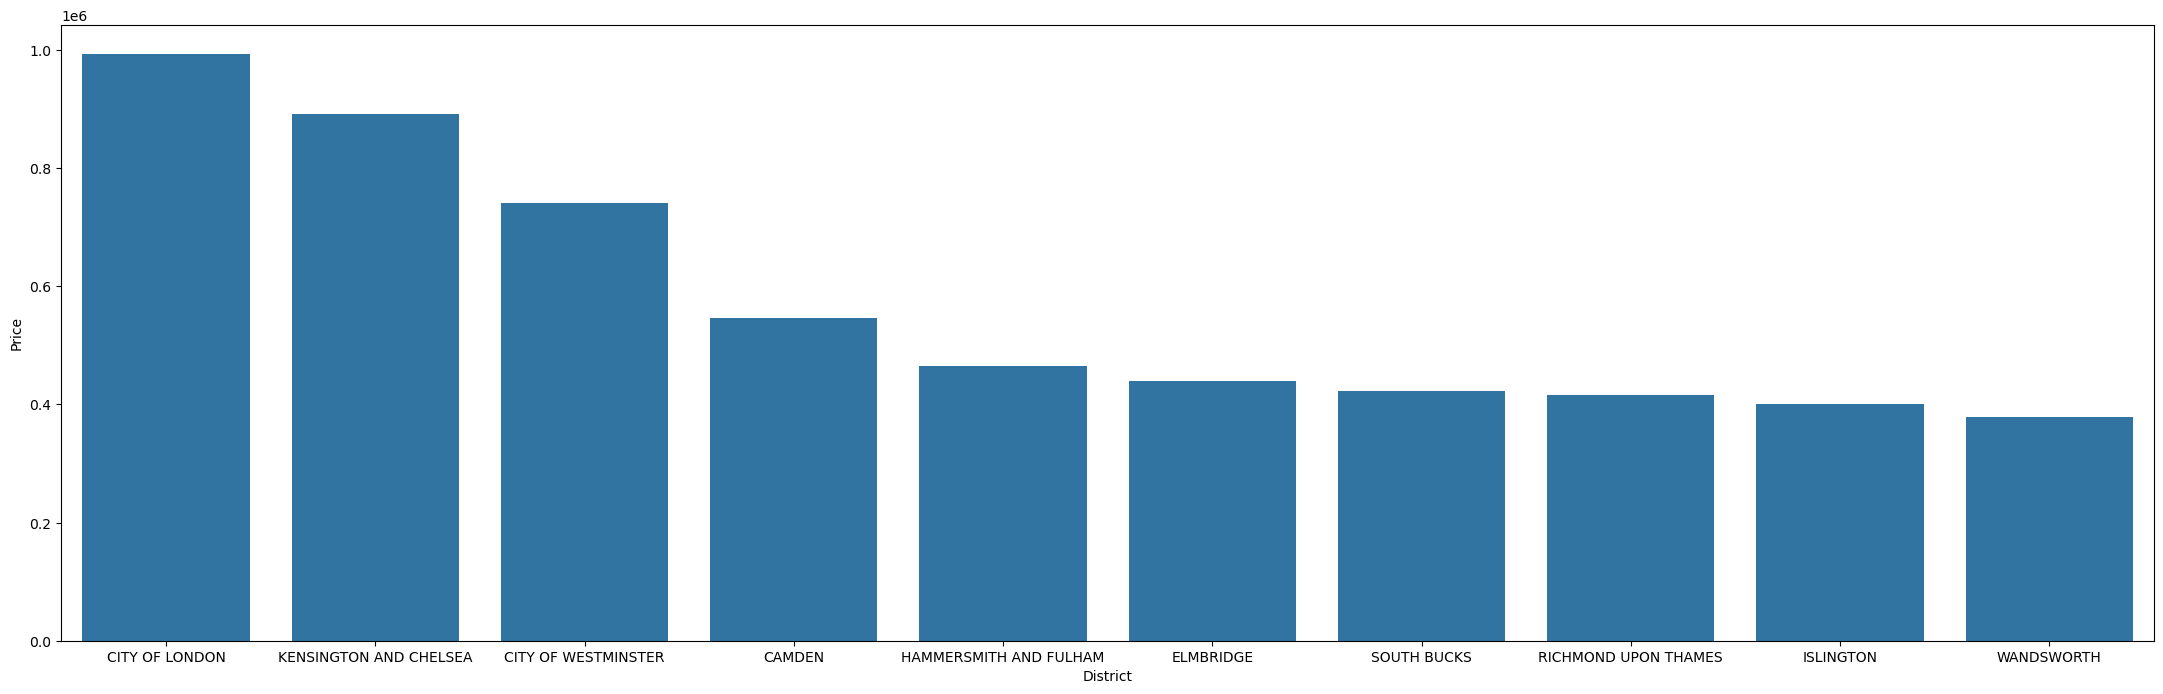

In [38]:
with Timer("cpu"):
    district_df = df.groupby('District')['Price'].mean().reset_index()
    district_df = district_df.sort_values(by=['Price'],ascending=False).head(10)
    plt.figure(figsize=(27,8))
    ax = sns.barplot(data = district_df, x = "District", y = "Price")

gpu execute time : 0.0603 seconds


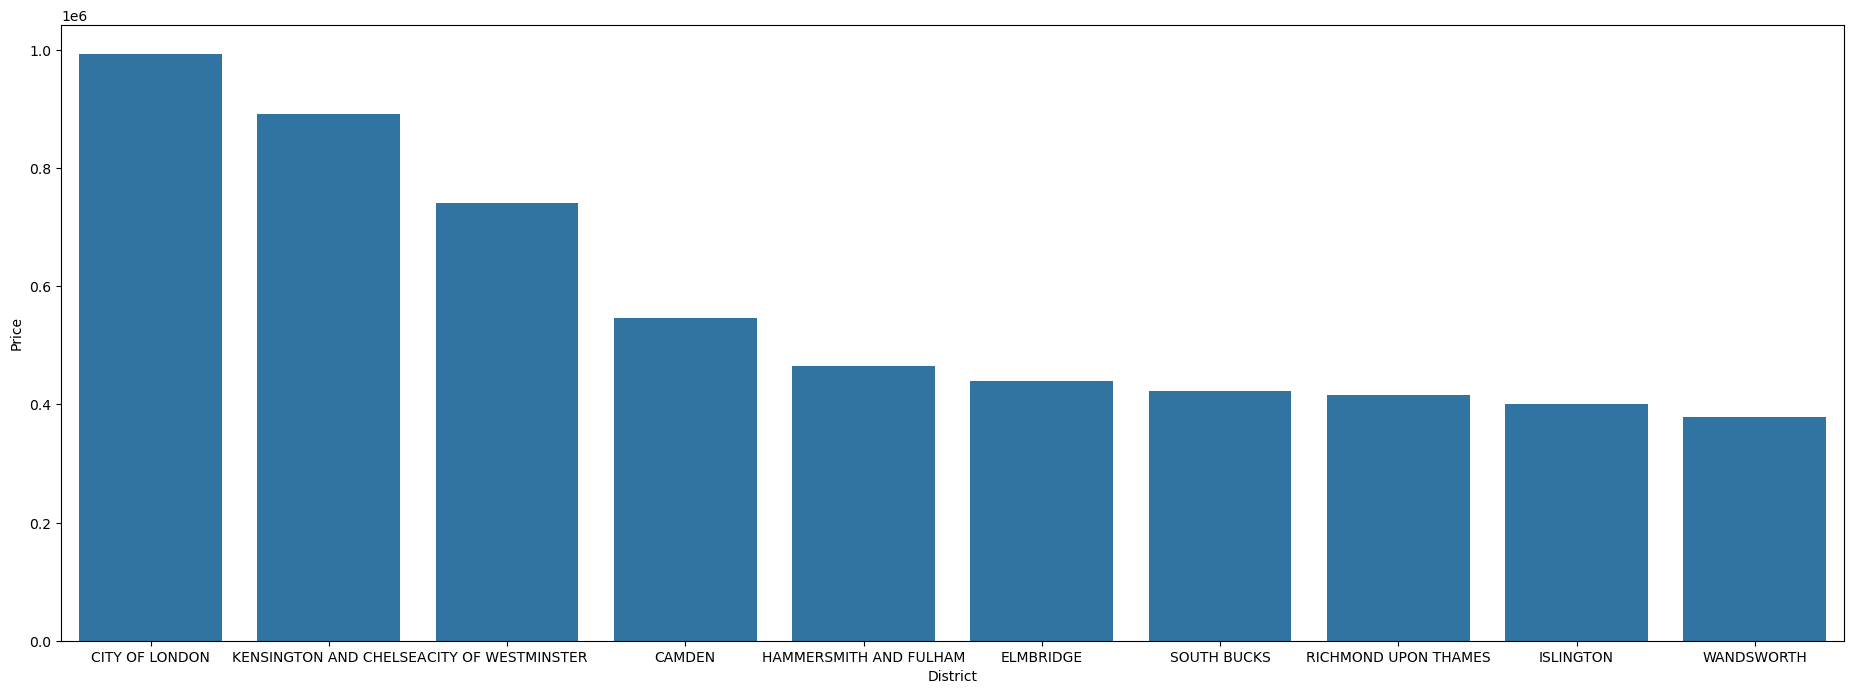

In [39]:
with Timer("gpu"):
    gprice = gdf.groupby("District")['Price'].mean()
    gprice = gprice.sort_values(ascending=False).head(10).reset_index()
    plt.figure(figsize=(23,8))
    ax = sns.barplot(data = gprice.to_pandas(), x = "District", y = "Price")


## Acknowledgements
---

This work procced by modulabs's NVIDIA - Data Engineering with RAPIDS in Korea <br/>
Learn more : <br/>

<a href="https://modulabs.notion.site/NVIDIA-Data-Engineering-with-RAPIDS-LAB-136c69bcb0f34c458e7553b945dacad7?pvs=4">
<img  src="https://img.shields.io/badge/notion-000000?style=flat-square&logo=notion&logoColor=FFFFFF" />
</a>
<a href="https://modulabs.co.kr/">
<img  src="https://img.shields.io/badge/모두의-연구소-FE5196?style=flat-square" />
</a>
<a href="https://www.youtube.com/watch?v=1c3Zw31JhgQ">
<img  src="https://img.shields.io/badge/Youtube-FF0000?style=flat-square&logo=youtube&logoColor=FFFFFF" />
</a>